# 9. CNNによる画像認識

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# warning表示off
import warnings
warnings.simplefilter('ignore')
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (5,5)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


- CNNの一般的な構造

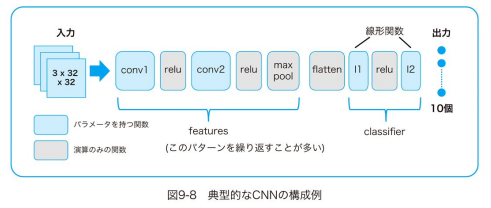

- 手順
    - 学習用データの準備
    - モデル定義→学習

In [4]:
#
# データ準備
#

# 正規化 & 1階テンソルへの変換
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# 正規化のみ
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

# 32 x 32 のカラー画像で10カテゴリに分けられている
# 訓練が5万枚で，検証用が1万枚のデータ

data_root = './data'
# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)
# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)
# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)
# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 確認
# 1階テンソル
image1, label1 = train_set1[0]
# 3階テンソル版
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [6]:
#
# データローダーの定義
#

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)
# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 

In [7]:
# データローダーから1枚取得して確認

for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


In [8]:
def show_images_labels(loader, classes, net, device):
    """
    イメージとラベルを表示する用の関数
    """
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

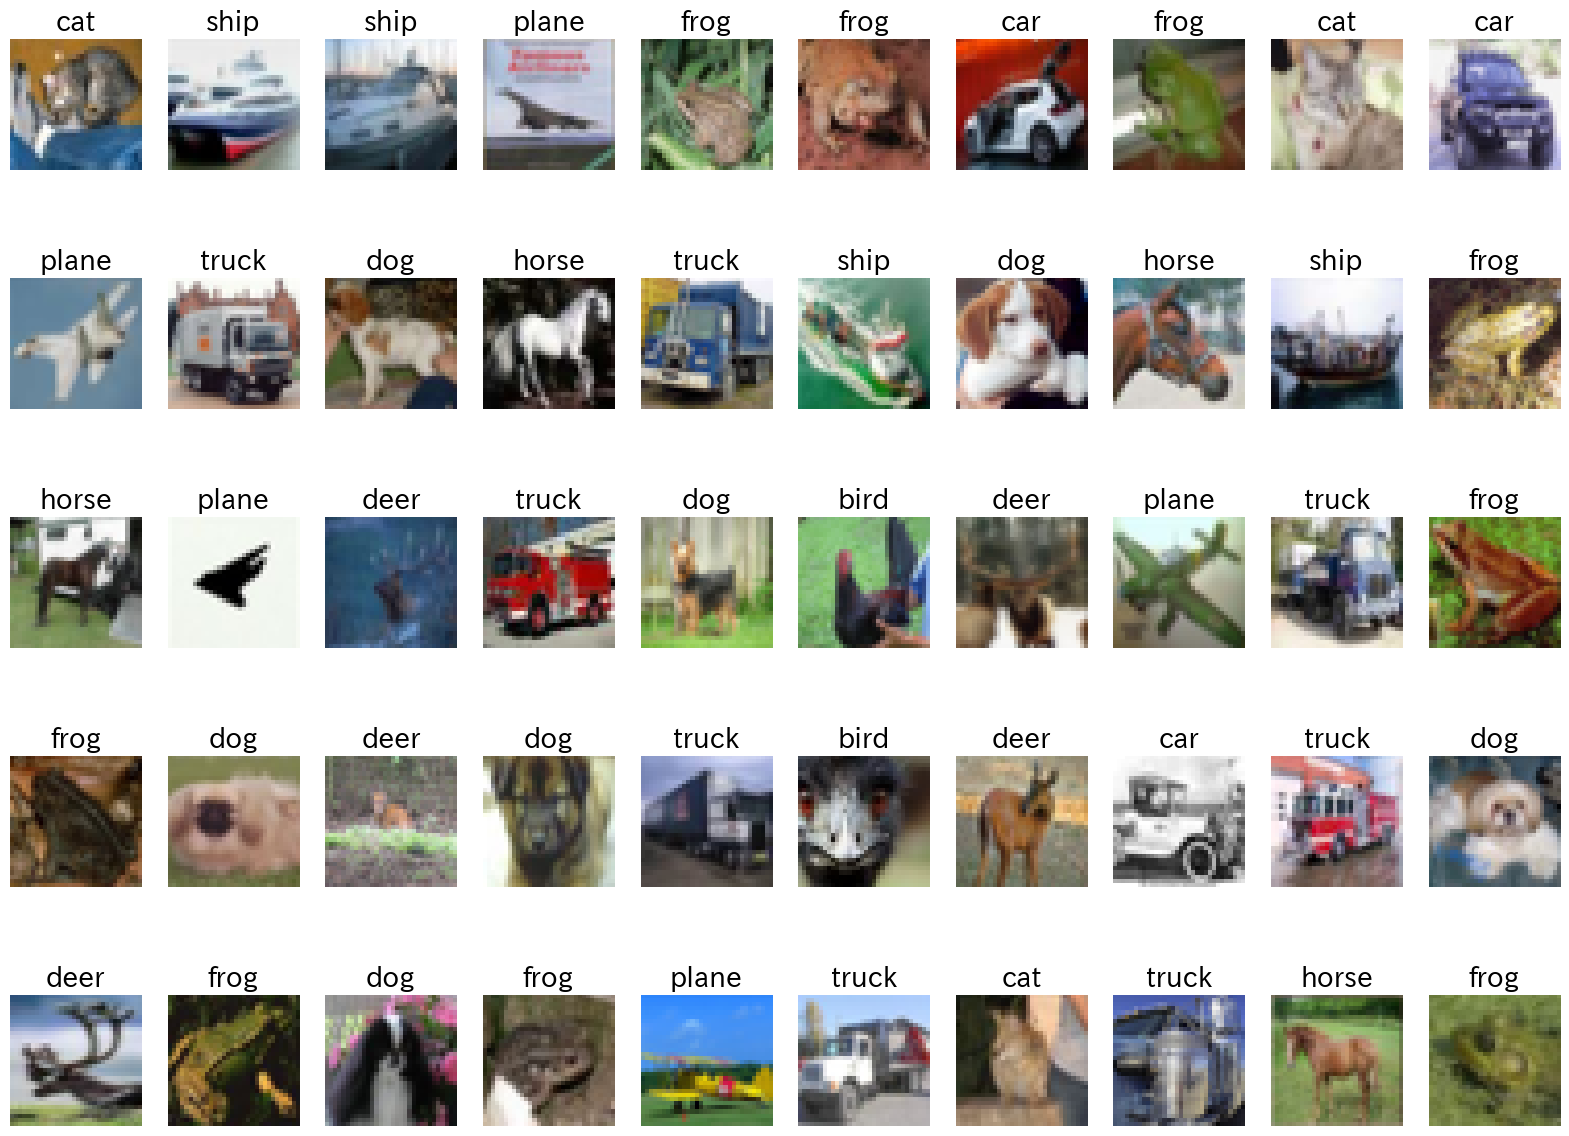

In [9]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

In [14]:
#
# 全結合モデルで予測をして精度を計測してみる(前回の復習みたいなもん)
#

# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]
# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)
# 隠れ層のノード数
n_hidden = 128
# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [15]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)
        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)
        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [16]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)
# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 学習率
lr = 0.01
# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [17]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [18]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

In [20]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

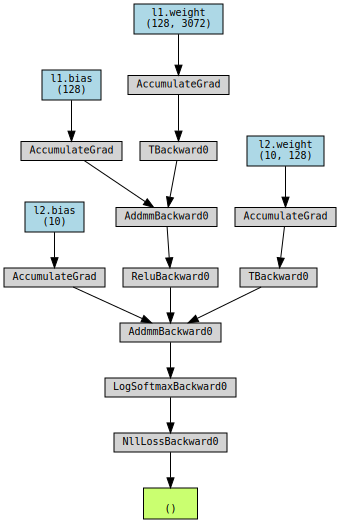

In [21]:
# 損失計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [22]:
# 繰り返し学習をする

In [23]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [32]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    # for epoch in range(base_epochs, num_epochs+base_epochs):
    for epoch in tqdm(range(base_epochs, num_epochs+base_epochs)):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ .. dropoutとか使うときに必要なので入れておく
        net.train()

        # 毎バッチの毎エポックでバーが出るのはだるい
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 勾配の初期化
            optimizer.zero_grad()
            # 予測計算
            outputs = net(inputs)
            # 損失計算
            loss = criterion(outputs, labels)
            # 勾配計算
            loss.backward()
            # パラメータ修正
            optimizer.step()
            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]
            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 
        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size
            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            # 予測計算
            outputs_test = net(inputs_test)
            # 損失計算
            loss_test = criterion(outputs_test, labels_test)
            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]
            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [30]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.94965 acc: 0.32218 val_loss: 1.79424, val_acc: 0.37710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73836 acc: 0.39598 val_loss: 1.68423, val_acc: 0.41850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.65492 acc: 0.42398 val_loss: 1.62226, val_acc: 0.43860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.60224 acc: 0.44248 val_loss: 1.58249, val_acc: 0.45090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.56314 acc: 0.45532 val_loss: 1.55321, val_acc: 0.46160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.53229 acc: 0.46752 val_loss: 1.52972, val_acc: 0.46910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.50485 acc: 0.47660 val_loss: 1.51216, val_acc: 0.47410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.48005 acc: 0.48608 val_loss: 1.49296, val_acc: 0.47750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.45685 acc: 0.49564 val_loss: 1.47968, val_acc: 0.48650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.43476 acc: 0.50418 val_loss: 1.46302, val_acc: 0.48840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.41324 acc: 0.51114 val_loss: 1.45008, val_acc: 0.49620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.39431 acc: 0.51972 val_loss: 1.43706, val_acc: 0.50230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.37507 acc: 0.52616 val_loss: 1.42530, val_acc: 0.50450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.35703 acc: 0.53442 val_loss: 1.42260, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.34071 acc: 0.53950 val_loss: 1.40720, val_acc: 0.51350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.32402 acc: 0.54566 val_loss: 1.40150, val_acc: 0.51120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.30742 acc: 0.55162 val_loss: 1.39043, val_acc: 0.51370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.29341 acc: 0.55664 val_loss: 1.38816, val_acc: 0.51450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.27869 acc: 0.56190 val_loss: 1.37908, val_acc: 0.52020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.26400 acc: 0.56616 val_loss: 1.38055, val_acc: 0.51830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25135 acc: 0.57136 val_loss: 1.37201, val_acc: 0.51730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.23770 acc: 0.57678 val_loss: 1.36793, val_acc: 0.52430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.22520 acc: 0.57968 val_loss: 1.36278, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.21334 acc: 0.58440 val_loss: 1.35496, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.20041 acc: 0.59178 val_loss: 1.35221, val_acc: 0.52760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.18952 acc: 0.59386 val_loss: 1.35085, val_acc: 0.52780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.17769 acc: 0.59936 val_loss: 1.34895, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.16673 acc: 0.60272 val_loss: 1.34334, val_acc: 0.52940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.15589 acc: 0.60580 val_loss: 1.34249, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.14508 acc: 0.60950 val_loss: 1.34546, val_acc: 0.52910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.13490 acc: 0.61438 val_loss: 1.34022, val_acc: 0.52920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.12450 acc: 0.61782 val_loss: 1.33773, val_acc: 0.52800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.11483 acc: 0.62128 val_loss: 1.33819, val_acc: 0.53110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.10516 acc: 0.62572 val_loss: 1.34107, val_acc: 0.52740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.09545 acc: 0.62856 val_loss: 1.34024, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.08606 acc: 0.63290 val_loss: 1.33330, val_acc: 0.53280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.07688 acc: 0.63636 val_loss: 1.33829, val_acc: 0.52780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.06783 acc: 0.63942 val_loss: 1.33494, val_acc: 0.53000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.05931 acc: 0.64140 val_loss: 1.34054, val_acc: 0.52950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.05075 acc: 0.64498 val_loss: 1.34794, val_acc: 0.52090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.04084 acc: 0.64938 val_loss: 1.33921, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.03307 acc: 0.65130 val_loss: 1.34725, val_acc: 0.52700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.02523 acc: 0.65280 val_loss: 1.34472, val_acc: 0.52570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.01639 acc: 0.65600 val_loss: 1.34506, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.00726 acc: 0.65944 val_loss: 1.34412, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.00055 acc: 0.66220 val_loss: 1.34296, val_acc: 0.52920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.99336 acc: 0.66506 val_loss: 1.34626, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.98486 acc: 0.66860 val_loss: 1.34986, val_acc: 0.52940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.97700 acc: 0.67052 val_loss: 1.36113, val_acc: 0.52070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.97045 acc: 0.67200 val_loss: 1.35116, val_acc: 0.52980


In [29]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

初期状態: 損失: 1.79424 精度: 0.37710
最終状態: 損失: 1.35116 精度: 0.52980


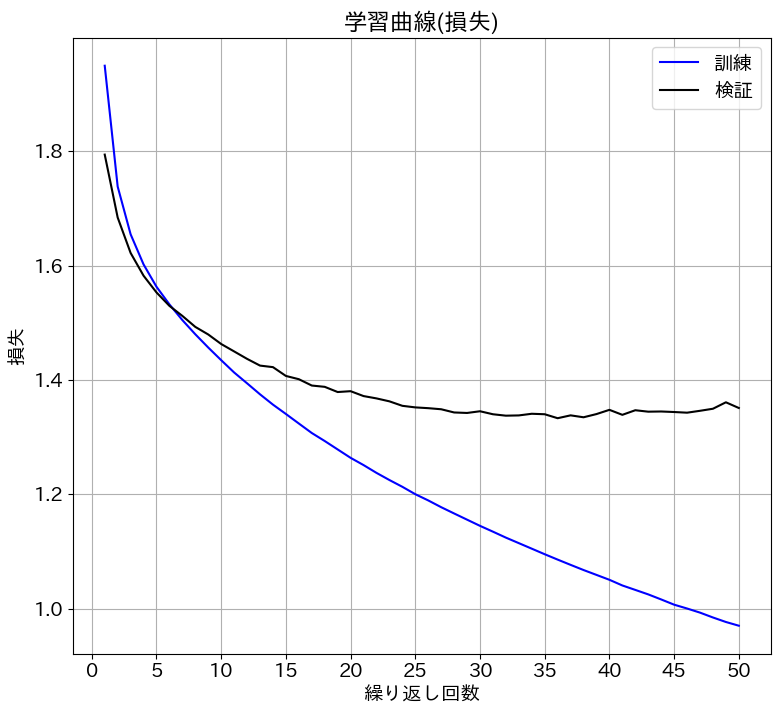

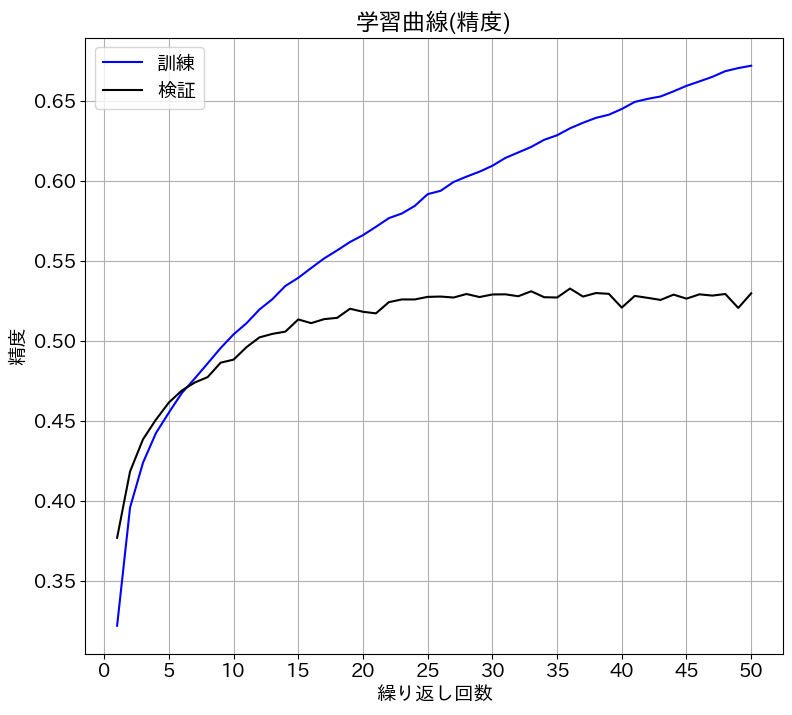

In [31]:
# 評価

evaluate_history(history)

In [33]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    # 第1引数は入力チャネル数 RGBで3
    # 第2引数は出力チャネル数
    # 第3引数はカーネルのサイズ
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3 
  
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08244 acc: 0.26080 val_loss: 1.86600, val_acc: 0.34690
Epoch [2/50], loss: 1.78075 acc: 0.37260 val_loss: 1.67671, val_acc: 0.40950
Epoch [3/50], loss: 1.61304 acc: 0.43066 val_loss: 1.53038, val_acc: 0.45960
Epoch [4/50], loss: 1.48508 acc: 0.47350 val_loss: 1.44941, val_acc: 0.48880
Epoch [5/50], loss: 1.40776 acc: 0.49996 val_loss: 1.37016, val_acc: 0.51190
Epoch [6/50], loss: 1.34967 acc: 0.52086 val_loss: 1.33233, val_acc: 0.52660
Epoch [7/50], loss: 1.30329 acc: 0.53724 val_loss: 1.29293, val_acc: 0.53730
Epoch [8/50], loss: 1.25268 acc: 0.55486 val_loss: 1.25495, val_acc: 0.55160
Epoch [9/50], loss: 1.20543 acc: 0.57422 val_loss: 1.23771, val_acc: 0.56010
Epoch [10/50], loss: 1.15812 acc: 0.59188 val_loss: 1.18365, val_acc: 0.58000
Epoch [11/50], loss: 1.11703 acc: 0.60804 val_loss: 1.16488, val_acc: 0.58770
Epoch [12/50], loss: 1.07805 acc: 0.62414 val_loss: 1.17259, val_acc: 0.58310
Epoch [13/50], loss: 1.03656 acc: 0.63686 val_loss: 1.11169, val_acc: 0.6

初期状態: 損失: 1.86600 精度: 0.34690
最終状態: 損失: 1.88406 精度: 0.66320


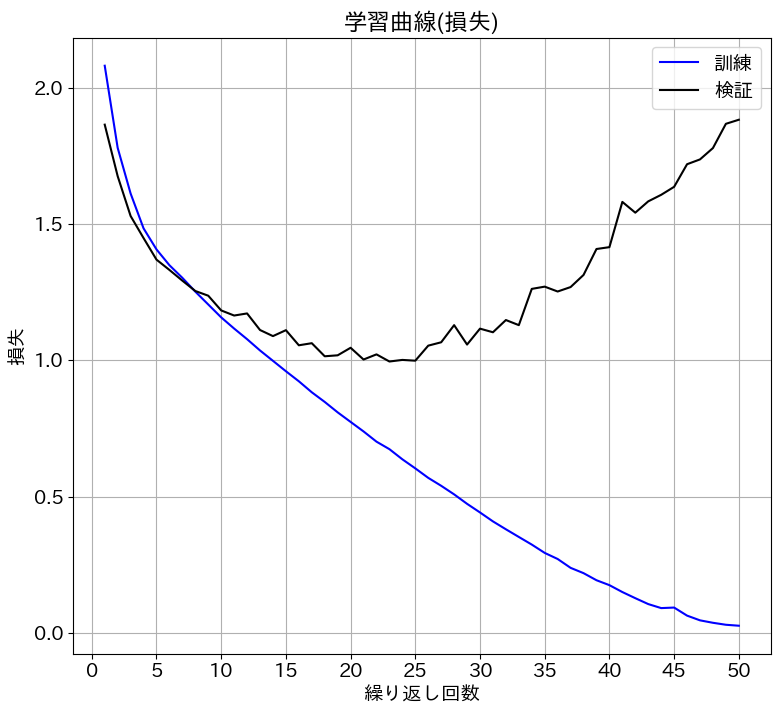

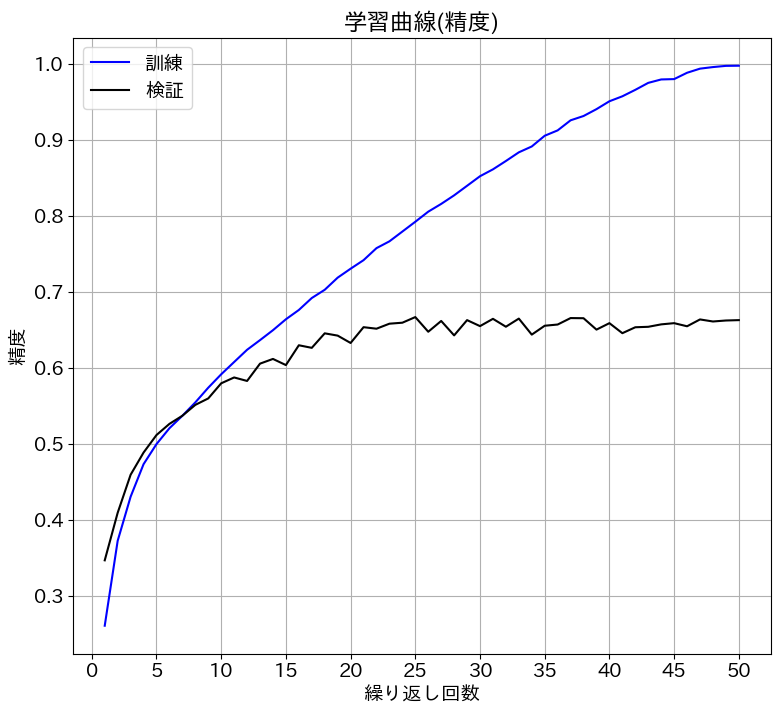

In [34]:
# 評価

evaluate_history(history2)